In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Selecting an image an then preprocessing it by turning it in grey scale, blurring it and then finding the edges.

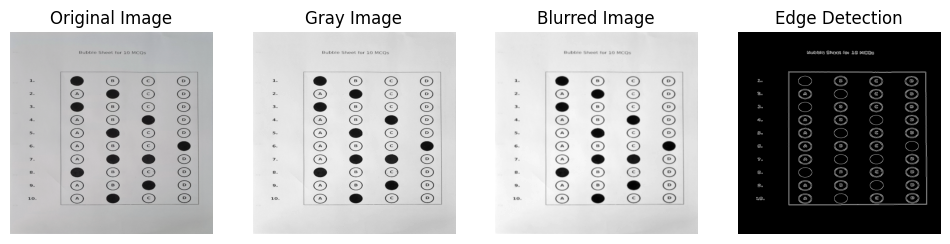

In [77]:
# Load the Image
pathImage = "C:/Users/itiss/Desktop/CV/Project/Test2.jpg"
heightImg, widthImg = 700, 700  

# Load and resize
img = cv2.imread(pathImage)
img = cv2.resize(img, (widthImg, heightImg))

# Preprocessing: Grayscale, Blur, and Edge Detection
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)
imgCanny = cv2.Canny(imgBlur, 50, 150)

# Display Preprocessing Steps
plt.figure(figsize=(12, 6))
titles = ["Original Image", "Gray Image", "Blurred Image", "Edge Detection"]
images = [img, imgGray, imgBlur, imgCanny]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap="gray" if i > 0 else None)
    plt.title(titles[i])
    plt.axis("off")
plt.show()


### Functions to find largest rectangle in which bubble grid is present, to split and draw the grid.

In [69]:

#Reorders four points of a quadrilateral to a consistent order: top-left, top-right, bottom-left, bottom-right, using the sum and difference of coordinates.
def reOrder(points):
    points = points.reshape((4, 2))
    newPoint = np.zeros((4, 1, 2), np.int32)
    add = points.sum(1)
    newPoint[0] = points[np.argmin(add)]
    newPoint[3] = points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    newPoint[1] = points[np.argmin(diff)]
    newPoint[2] = points[np.argmax(diff)]
    return newPoint

#Filters contours to keep only quadrilaterals with an area > 50, approximates their shape, and returns them sorted by area in descending order.
def rectangleContour(contours):
    rectCon = []
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:  # contour area
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if len(approx) == 4:  # Only keep rectangular contours
                rectCon.append(i)
    return sorted(rectCon, key=cv2.contourArea, reverse=True)

#Splits an image into questions rows and choices columns, returning individual cropped boxes for further processing.
def splitBoxes(img, questions=10, choices=4):
    rows = np.vsplit(img, questions)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, choices)
        boxes.extend(cols)
    return boxes

#Overlays a grid on the image by drawing horizontal and vertical lines based on the specified rows and cols.
def drawGrid(img, rows=10, cols=4):
    h, w = img.shape[:2]
    for i in range(1, rows):
        cv2.line(img, (0, i * (h // rows)), (w, i * (h // rows)), (0, 0, 255), 2)
    for j in range(1, cols):
        cv2.line(img, (j * (w // cols), 0), (j * (w // cols), h), (0, 0, 255), 2)

#Enables interactive selection of a rectangular Region of Interest (ROI) using the mouse, dynamically updating the rectangle as the user drags.
def selectROI(event, x, y, flags, param):
    global selected_points, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        selected_points = [(x, y)] 

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            temp_img = img.copy() 
            cv2.rectangle(temp_img, selected_points[0], (x, y), (0, 255, 0), 2)
            cv2.imshow("Select Rectangle", temp_img)
            
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        selected_points.append((x, y)) 
        cv2.rectangle(img, selected_points[0], selected_points[1], (0, 255, 0), 2)
        cv2.imshow("Select Rectangle", img)


### Finding Largest Contour (Rectangle).

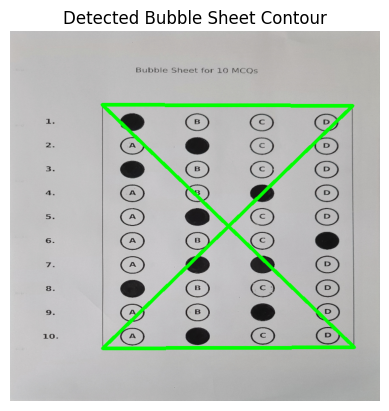

In [78]:
contours, _ = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rectCon = rectangleContour(contours)  # Get rectangular contours

if rectCon:
    biggestPoints = reOrder(cv2.approxPolyDP(rectCon[0], 0.02 * cv2.arcLength(rectCon[0], True), True))

    # Draw the detected rectangle
    imgContours = img.copy()
    cv2.drawContours(imgContours, [biggestPoints], -1, (0, 255, 0), 5)

    # Display
    plt.imshow(cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB))
    plt.title("Detected Bubble Sheet Contour")
    plt.axis("off")
    plt.show()
else:
    print("No rectangular contour detected.")
    print("Please manually select the region of interest.")
        # Initialize drawing flags and selected points
    selected_points = []
    drawing = False

    # Set the mouse callback function
    cv2.namedWindow("Select Rectangle")
    cv2.setMouseCallback("Select Rectangle", selectROI)

    # Display the image and allow the user to select a region
    cv2.imshow("Select Rectangle", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # If the user selected a rectangle, draw it
    if len(selected_points) == 2:
        x1, y1 = selected_points[0]
        x2, y2 = selected_points[1]
        rect = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.int32)
        
        # Reorder the points if necessary
        biggestPoints = reOrder(rect)

        # Draw the selected rectangle
        imgContours = img.copy()
        cv2.drawContours(imgContours, [biggestPoints], -1, (0, 255, 0), 5)

        # Display the selected rectangle
        plt.imshow(cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB))
        plt.title("Manually Selected Bubble Sheet Contour")
        plt.axis("off")
        plt.show()




### Cropping the Grid and Thresholding it.

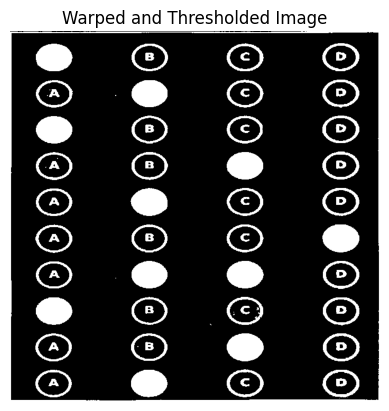

In [79]:
if biggestPoints.size != 0:
    pts1 = np.float32(biggestPoints)
    pts2 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    
    # Grayscale and Threshold
    imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
    imgThresh = cv2.threshold(imgWarpGray, 170, 255, cv2.THRESH_BINARY_INV)[1]
    
    # Display
    plt.imshow(imgThresh, cmap="gray")
    plt.title("Warped and Thresholded Image")
    plt.axis("off")
    plt.show()
else:
    print("Perspective transformation failed.")


### Spliting the Grid

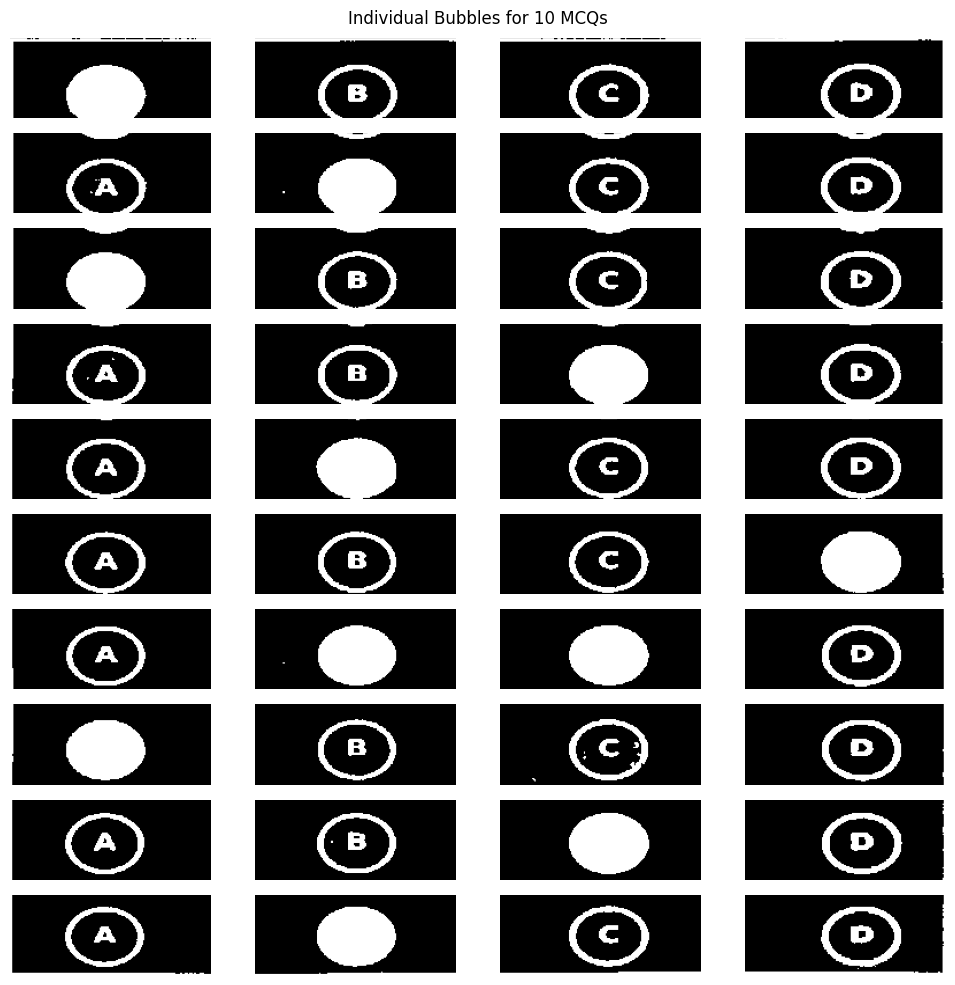

In [80]:
boxes = splitBoxes(imgThresh)

questions = 10
choices = 4

plt.figure(figsize=(10, 10))

for i in range(questions * choices):  
    plt.subplot(questions, choices, i + 1)
    plt.imshow(boxes[i], cmap="gray")
    plt.axis("off") 

plt.suptitle("Individual Bubbles for 10 MCQs", fontsize=12)
plt.tight_layout()
plt.show()


### Finding the Filled Bubbles

In [81]:
myPixelVal = np.zeros((questions, choices)) 

# Detect filled bubbles
countR, countC = 0, 0
for image in boxes:
    totalPixels = cv2.countNonZero(image)
    myPixelVal[countR][countC] = totalPixels
    countC += 1
    if countC == choices:
        countC = 0
        countR += 1

# Determine the filled options for each question
myIndex = []
for x in range(questions):
    # Threshold
    threshold = np.max(myPixelVal) * 0.65
    print(f"Q{x+1}: Threshold for marking options: {threshold:.2f}")

#############################################PRINTING THE VALUES OF ALL THE BUBBLES FR DEBUGGING#####################################################
    for c in range(choices):
        print(f"Option {['A', 'B', 'C', 'D'][c]} - Pixel Count: {myPixelVal[x][c]}")
#####################################################################################################################################################

# Bubbles above threshold
    filledBubbles = np.where(myPixelVal[x] > threshold)[0]
    print(f"Filled options for Q{x+1}: {filledBubbles}")

    if len(filledBubbles) > 1:
        # Multiple bubbles filled - mark as incorrect
        myIndex.append('Invalid')
        print(f"Q{x+1}: Multiple options filled (Invalid)")
    elif len(filledBubbles) == 1:
        # Single bubble filled
        myIndex.append(filledBubbles[0])
        print(f"Q{x+1}: Option {['A', 'B', 'C', 'D'][filledBubbles[0]]} selected")
    else:
        # No bubble filled
        myIndex.append('Unanswered')
        print(f"Q{x+1}: No option selected (Unanswered)")

# Output the results
options = ['A', 'B', 'C', 'D']
for i, idx in enumerate(myIndex):
    if idx == 'Invalid':
        print(f"Q{i+1}: Multiple options filled (Invalid)")
    elif idx == 'Unanswered':
        print(f"Q{i+1}: No option selected")
    else:
        print(f"Q{i+1}: {options[idx]} selected")


Q1: Threshold for marking options: 2146.30
Option A - Pixel Count: 3302.0
Option B - Pixel Count: 1364.0
Option C - Pixel Count: 1392.0
Option D - Pixel Count: 1809.0
Filled options for Q1: [0]
Q1: Option A selected
Q2: Threshold for marking options: 2146.30
Option A - Pixel Count: 1328.0
Option B - Pixel Count: 2837.0
Option C - Pixel Count: 1102.0
Option D - Pixel Count: 1448.0
Filled options for Q2: [1]
Q2: Option B selected
Q3: Threshold for marking options: 2146.30
Option A - Pixel Count: 3089.0
Option B - Pixel Count: 1100.0
Option C - Pixel Count: 1085.0
Option D - Pixel Count: 1449.0
Filled options for Q3: [0]
Q3: Option A selected
Q4: Threshold for marking options: 2146.30
Option A - Pixel Count: 1273.0
Option B - Pixel Count: 1080.0
Option C - Pixel Count: 2867.0
Option D - Pixel Count: 1425.0
Filled options for Q4: [2]
Q4: Option C selected
Q5: Threshold for marking options: 2146.30
Option A - Pixel Count: 1171.0
Option B - Pixel Count: 2878.0
Option C - Pixel Count: 1027.0


### Drawing the Grid after selecting the marked Bubbles
##### ->Green if only one selected, Red if multiple selected.

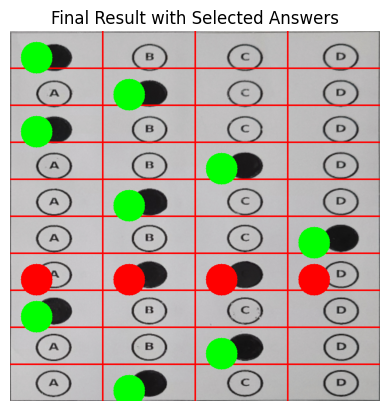

In [82]:

drawGrid(imgWarpColored)

for i, idx in enumerate(myIndex):
    if idx == 'Invalid':
        for j in range(choices):
            x = (j * (widthImg // choices)) + 50
            y = (i * (heightImg // questions)) + 50
            cv2.circle(imgWarpColored, (x, y), 30, (0, 0, 255), cv2.FILLED)
    elif idx == 'Unanswered':
        continue
    else:
        x = (idx * (widthImg // choices)) + 50
        y = (i * (heightImg // questions)) + 50
        cv2.circle(imgWarpColored, (x, y), 30, (0, 255, 0), cv2.FILLED)

# Display the final image
plt.imshow(cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2RGB))
plt.title("Final Result with Selected Answers")
plt.axis("off")
plt.show()

### Main Logic for marking the sheet

In [92]:
print("Marking Scheme:")
print("- Correct Answer: +1 point")
print("- Incorrect Answer: -0.25 points")
print("- Multiple Options Selected (Invalid): -0.5 points")
print("- Unanswered: 0 points\n")

detectedAnswers = [] 
options = ['A', 'B', 'C', 'D']

for idx in myIndex:
    if idx == 'Invalid':
        detectedAnswers.append('Invalid')
    elif idx == 'Unanswered':
        detectedAnswers.append('Unanswered')
    else:
        detectedAnswers.append(options[idx])

# Define the answer key
answer_key = ['A', 'B', 'A', 'C', 'B', 'D', 'B', 'A', 'C', 'A']

correctAnswers = 0
invalidAnswers = 0
unansweredQuestions = 0
incorrectAnswers = 0
totalScore = 0
negativeMarks = 0

for i in range(len(answer_key)):
    if detectedAnswers[i] == 'Invalid':
        invalidAnswers += 1
        negativeMarks += 0.5  # negative marking for multiple choices
        totalScore -= 0.5
        print(f"Q{i+1}: Invalid - Multiple options selected (-0.5)")
    elif detectedAnswers[i] == 'Unanswered':
        unansweredQuestions += 1
        print(f"Q{i+1}: Unanswered")
    elif detectedAnswers[i] == answer_key[i]:
        correctAnswers += 1
        totalScore += 1  # Add 1 for each correct answer
        print(f"Q{i+1}: Correct - {detectedAnswers[i]} (+1)")
    else:
        incorrectAnswers += 1
        negativeMarks += 0.25  # negative marking for incorrect answers
        totalScore -= 0.25
        print(f"Q{i+1}: Incorrect - Selected {detectedAnswers[i]}, Correct answer was {answer_key[i]} (-0.25)")

# Display summary results
print("\nSummary:")
print(f"Correct Answers: {correctAnswers}/{len(answer_key)}")
print(f"Invalid Answers (Multiple Choices): {invalidAnswers}")
print(f"Unanswered Questions: {unansweredQuestions}")
print(f"Incorrect Answers: {incorrectAnswers}")
print(f"Negative Marks: {negativeMarks:.2f}")
print(f"Total Score: {max(0, totalScore):.2f}/{len(answer_key)}")


Marking Scheme:
- Correct Answer: +1 point
- Incorrect Answer: -0.25 points
- Multiple Options Selected (Invalid): -0.5 points
- Unanswered: 0 points

Q1: Correct - A (+1)
Q2: Correct - B (+1)
Q3: Correct - A (+1)
Q4: Correct - C (+1)
Q5: Correct - B (+1)
Q6: Correct - D (+1)
Q7: Invalid - Multiple options selected (-0.5)
Q8: Correct - A (+1)
Q9: Correct - C (+1)
Q10: Incorrect - Selected B, Correct answer was A (-0.25)

Summary:
Correct Answers: 8/10
Invalid Answers (Multiple Choices): 1
Unanswered Questions: 0
Incorrect Answers: 1
Negative Marks: 0.75
Total Score: 7.25/10
